# One-Step Real-World ×4 Super-Resolution (FluxSR-style) with Z-Image (Diffusers)

This notebook is a **practical starting point** for building the **offline (noise, HR) pair dataset** and setting up **training-time inputs** for a FluxSR / Flow-Trajectory-Distillation style method, but using **Z-Image** instead of FLUX.

It focuses on:
- Loading `ZImageImg2ImgPipeline`
- Inspecting whether the pipeline supports `prompt_embeds`
- Caching **null prompt embeddings** once (to avoid keeping the 4B text encoder on GPU)
- Generating **unconditional HR samples** from fixed noise
- Saving an offline dataset of `(eps, z0)` (and optionally `x0`) for later SR training

> Notes:
> - The *teacher* here is the frozen Z-Image model used to generate HR samples.
> - The offline dataset is what lets you train a lightweight SR student **without the teacher in memory**.


In [1]:
!pip -q install -U diffusers transformers accelerate safetensors torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39

In [3]:
import os
import math
import json
import torch
from pathlib import Path
from PIL import Image
import numpy as np

from diffusers import ZImageImg2ImgPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

model_id = "Tongyi-MAI/Z-Image-Turbo"
out_dir = Path("./zimage_offline_pairs")
out_dir.mkdir(parents=True, exist_ok=True)

print("Device:", device, "dtype:", dtype)


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Device: cuda dtype: torch.bfloat16


In [9]:
pipe = ZImageImg2ImgPipeline.from_pretrained(
    model_id,
    torch_dtype=dtype,
)
pipe.to(device)

# Print parameter counts
def count_params(m):
    return sum(p.numel() for p in m.parameters())

print(f"Transformer params: {count_params(pipe.transformer):,}")
if hasattr(pipe, "text_encoder") and pipe.text_encoder is not None:
    print(f"Text encoder params: {count_params(pipe.text_encoder):,}")
if hasattr(pipe, "vae") and pipe.vae is not None:
    print(f"VAE params: {count_params(pipe.vae):,}")


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

Transformer params: 6,154,908,736
Text encoder params: 4,022,468,096
VAE params: 83,819,683


In [10]:
import inspect

sig = inspect.signature(pipe.__call__)
print(sig)

# Quick hint about embed bypass
supports_prompt_embeds = ("prompt_embeds" in sig.parameters)
supports_negative_prompt_embeds = ("negative_prompt_embeds" in sig.parameters)
print("Supports prompt_embeds:", supports_prompt_embeds)
print("Supports negative_prompt_embeds:", supports_negative_prompt_embeds)


(prompt: Union[str, List[str]] = None, image: Union[PIL.Image.Image, numpy.ndarray, torch.Tensor, List[PIL.Image.Image], List[numpy.ndarray], List[torch.Tensor]] = None, strength: float = 0.6, height: Optional[int] = None, width: Optional[int] = None, num_inference_steps: int = 50, sigmas: Optional[List[float]] = None, guidance_scale: float = 5.0, cfg_normalization: bool = False, cfg_truncation: float = 1.0, negative_prompt: Union[str, List[str], NoneType] = None, num_images_per_prompt: Optional[int] = 1, generator: Union[torch._C.Generator, List[torch._C.Generator], NoneType] = None, latents: Optional[torch.FloatTensor] = None, prompt_embeds: Optional[List[torch.FloatTensor]] = None, negative_prompt_embeds: Optional[List[torch.FloatTensor]] = None, output_type: Optional[str] = 'pil', return_dict: bool = True, joint_attention_kwargs: Optional[Dict[str, Any]] = None, callback_on_step_end: Optional[Callable[[int, int, Dict], NoneType]] = None, callback_on_step_end_tensor_inputs: List[str

## 1) Cache a *null prompt* embedding once (if supported)

Goal: generate unconditional teacher samples while **not** keeping the 4B text encoder on GPU.

If `prompt_embeds` is supported:
1. Encode `prompt=""` once
2. Save the embeddings to disk
3. Move text encoder to CPU / unload
4. Pass `prompt_embeds` directly for all subsequent sampling


In [11]:
import torch
import inspect

null_emb_path = out_dir / "null_prompt_embeds.pt"

null_prompt = ""
negative_prompt = ""

def unwrap_first_tensor(x):
    """Return first tensor from list/tuple; return None for empty containers."""
    if x is None:
        return None
    if isinstance(x, (list, tuple)):
        if len(x) == 0:
            return None
        for v in x:
            if torch.is_tensor(v):
                return v
        # fallback: return first element if non-empty
        return x[0]
    return x

# Try to call encode_prompt robustly
def try_encode_prompt(pipe, prompt, negative_prompt=None, device=None, num_images_per_prompt=1, do_classifier_free_guidance=False):
    if not hasattr(pipe, "encode_prompt"):
        raise RuntimeError("Pipeline has no encode_prompt method.")
    enc_sig = inspect.signature(pipe.encode_prompt)
    kwargs = {}
    if "device" in enc_sig.parameters:
        kwargs["device"] = device
    if "num_images_per_prompt" in enc_sig.parameters:
        kwargs["num_images_per_prompt"] = num_images_per_prompt
    if "do_classifier_free_guidance" in enc_sig.parameters:
        kwargs["do_classifier_free_guidance"] = do_classifier_free_guidance
    if "negative_prompt" in enc_sig.parameters:
        kwargs["negative_prompt"] = negative_prompt
    return pipe.encode_prompt(prompt, **kwargs)

sig = inspect.signature(pipe.__call__)
supports_prompt_embeds = ("prompt_embeds" in sig.parameters)
supports_negative_prompt_embeds = ("negative_prompt_embeds" in sig.parameters)
print("Supports prompt_embeds:", supports_prompt_embeds)
print("Supports negative_prompt_embeds:", supports_negative_prompt_embeds)

null_prompt_embeds = None
null_negative_prompt_embeds = None

if supports_prompt_embeds:
    if null_emb_path.exists():
        data = torch.load(null_emb_path, map_location="cpu")
        null_prompt_embeds = data.get("prompt_embeds", None)
        null_negative_prompt_embeds = data.get("negative_prompt_embeds", None)
        print("Loaded cached null prompt embeds:", null_emb_path)
    else:
        # IMPORTANT: ensure text_encoder is on the same device during encoding
        if hasattr(pipe, "text_encoder") and pipe.text_encoder is not None:
            prev_dev = next(pipe.text_encoder.parameters()).device
            pipe.text_encoder.to(device)
        else:
            prev_dev = None

        try:
            with torch.no_grad():
                enc = try_encode_prompt(
                    pipe,
                    prompt=null_prompt,
                    negative_prompt=negative_prompt,
                    device=device,
                    num_images_per_prompt=1,
                    do_classifier_free_guidance=False,
                )
        finally:
            if prev_dev is not None:
                pipe.text_encoder.to(prev_dev)

        # encode_prompt can return tensor OR (tensor, tensor) OR list/tuple structures
        if isinstance(enc, (tuple, list)):
            null_prompt_embeds = enc[0]
            null_negative_prompt_embeds = enc[1] if len(enc) > 1 else None
        else:
            null_prompt_embeds = enc

        # Normalize to tensors (or None)
        pe = unwrap_first_tensor(null_prompt_embeds)
        ne = unwrap_first_tensor(null_negative_prompt_embeds)

        torch.save(
            {
                "prompt_embeds": pe.detach().cpu() if torch.is_tensor(pe) else pe,
                "negative_prompt_embeds": (ne.detach().cpu() if torch.is_tensor(ne) else None),
            },
            null_emb_path
        )
        print("Saved cached null prompt embeds:", null_emb_path)

    # Normalize after load too
    null_prompt_embeds = unwrap_first_tensor(null_prompt_embeds)
    null_negative_prompt_embeds = unwrap_first_tensor(null_negative_prompt_embeds)

    # Print shape safely
    if torch.is_tensor(null_prompt_embeds):
        print("null_prompt_embeds shape:", tuple(null_prompt_embeds.shape))
    else:
        print("null_prompt_embeds type:", type(null_prompt_embeds), "value:", null_prompt_embeds)

else:
    print("This pipeline does not support prompt_embeds; will use prompt='' directly.")


Supports prompt_embeds: True
Supports negative_prompt_embeds: True
Loaded cached null prompt embeds: zimage_offline_pairs/null_prompt_embeds.pt
null_prompt_embeds shape: (8, 2560)


In [12]:
# Optional: offload / unload the text encoder after caching embeds to reduce VRAM.
# Only do this if prompt_embeds path is supported.
if supports_prompt_embeds and hasattr(pipe, "text_encoder") and pipe.text_encoder is not None:
    pipe.text_encoder.to("cpu")
    torch.cuda.empty_cache()
    print("Moved text_encoder to CPU.")


Moved text_encoder to CPU.


## 2) Teacher sampling: generate HR images from fixed noise

For the offline dataset you want to save:
- `eps` : the sampled Gaussian noise in **latent space**
- `z0`  : VAE latent of the resulting HR image

Depending on your later training setup you might also save:
- `x0`  : the decoded pixel HR image (PNG/JPEG) for on-the-fly degradation

This section generates `N` HR samples and stores:
- `pairs/{i:06d}/eps.pt`
- `pairs/{i:06d}/z0.pt`
- `pairs/{i:06d}/x0.png` (optional)


In [13]:
# Sampling config
N = 1200                # increase as needed (paper used 2400)
hr_size = 1024       # HR resolution
num_inference_steps = 30  # for teacher sampling; Turbo models may prefer fewer
guidance_scale = 0.0      # unconditional
save_x0_png = True

# A fixed generator seed for reproducibility
base_seed = 12345

# Utility: VAE encode image -> latent (z0)
@torch.no_grad()
def vae_encode_latents(pipe, pil_img: Image.Image):
    # Convert to tensor in [-1, 1]
    img = np.array(pil_img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2,0,1).unsqueeze(0)  # 1,3,H,W
    img = img * 2.0 - 1.0
    img = img.to(device=device, dtype=dtype)
    latents = pipe.vae.encode(img).latent_dist.sample()
    # Some VAEs need scaling_factor
    scaling = getattr(pipe.vae.config, "scaling_factor", 1.0)
    latents = latents * scaling
    return latents

# Utility: sample eps matching the latent shape for given HR size
@torch.no_grad()
def sample_eps_for_hr(pipe, hr_size, generator):
    # The VAE latent spatial size is typically hr/8 for SD-like VAEs, but we infer it:
    # Create a dummy image and encode once to get latent shape (cheap for one pass).
    dummy = Image.fromarray(np.zeros((hr_size, hr_size, 3), dtype=np.uint8))
    z = vae_encode_latents(pipe, dummy)
    eps = torch.randn_like(z, generator=generator)
    return eps, z.shape

# Decide latent shape once
g0 = torch.Generator(device=device).manual_seed(base_seed)
eps0, latent_shape = sample_eps_for_hr(pipe, hr_size, g0)
print("Inferred latent shape:", latent_shape)


Inferred latent shape: torch.Size([1, 16, 128, 128])


In [14]:
# Force the core modules to the same device/dtype
pipe.transformer.to(device=device, dtype=dtype)
pipe.vae.to(device=device, dtype=dtype)

# Keep text encoder wherever you want; but if you pass prompt_embeds, it can stay on CPU
if hasattr(pipe, "text_encoder") and pipe.text_encoder is not None:
    # optional: keep on CPU to save VRAM
    pipe.text_encoder.to("cpu")

torch.cuda.empty_cache()


In [15]:
import inspect
print(inspect.signature(pipe.__call__))


(prompt: Union[str, List[str]] = None, image: Union[PIL.Image.Image, numpy.ndarray, torch.Tensor, List[PIL.Image.Image], List[numpy.ndarray], List[torch.Tensor]] = None, strength: float = 0.6, height: Optional[int] = None, width: Optional[int] = None, num_inference_steps: int = 50, sigmas: Optional[List[float]] = None, guidance_scale: float = 5.0, cfg_normalization: bool = False, cfg_truncation: float = 1.0, negative_prompt: Union[str, List[str], NoneType] = None, num_images_per_prompt: Optional[int] = 1, generator: Union[torch._C.Generator, List[torch._C.Generator], NoneType] = None, latents: Optional[torch.FloatTensor] = None, prompt_embeds: Optional[List[torch.FloatTensor]] = None, negative_prompt_embeds: Optional[List[torch.FloatTensor]] = None, output_type: Optional[str] = 'pil', return_dict: bool = True, joint_attention_kwargs: Optional[Dict[str, Any]] = None, callback_on_step_end: Optional[Callable[[int, int, Dict], NoneType]] = None, callback_on_step_end_tensor_inputs: List[str

In [ ]:
import torch
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

def normalize_prompt_embeds(pe, device, dtype):
    """
    Z-Image expects prompt_embeds as a list of tensors.
    We:
      - keep list/tuple as list
      - move all tensor elements to device/dtype
      - prefer token-level embeddings (ndim >= 2) and drop 1D pooled vectors
    """
    if pe is None:
        return None

    # If a single tensor was provided, wrap it (but try to avoid 1D pooled)
    if torch.is_tensor(pe):
        if pe.ndim == 1:
            return None  # 1D pooled is not usable here
        return [pe.to(device=device, dtype=dtype)]

    if isinstance(pe, (list, tuple)):
        tens = [t for t in pe if torch.is_tensor(t)]
        # keep only token-like embeddings (2D/3D), drop 1D pooled vectors
        tens = [t for t in tens if t.ndim >= 2]
        if len(tens) == 0:
            return None
        return [t.to(device=device, dtype=dtype) for t in tens]

    raise TypeError(f"Unsupported prompt_embeds type: {type(pe)}")


# --- Robust helper: handles list/tuple outputs, empty lists, etc. ---
def unwrap_first_tensor(x):
    if x is None:
        return None
    if isinstance(x, (list, tuple)):
        if len(x) == 0:
            return None
        for v in x:
            if torch.is_tensor(v):
                return v
        return x[0]
    return x

# --- Robust VAE encode: guarantees matching device + dtype ---
@torch.no_grad()
def vae_encode_latents_safe(pipe, pil_img, device, dtype):
    # Ensure VAE on correct device/dtype
    pipe.vae.to(device=device, dtype=dtype)

    # PIL -> tensor in [-1, 1]
    img = np.array(pil_img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)  # 1,3,H,W
    img = img * 2.0 - 1.0
    img = img.to(device=device, dtype=dtype)

    latents = pipe.vae.encode(img).latent_dist.sample()
    scaling = getattr(pipe.vae.config, "scaling_factor", 1.0)
    latents = latents * scaling
    return latents

# --- Defaults if you ran cells out of order ---
if "device" not in globals():
    device = "cuda" if torch.cuda.is_available() else "cpu"
if "dtype" not in globals():
    dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

if "N" not in globals():
    N = 1200
if "save_x0_png" not in globals():
    save_x0_png = True
if "supports_prompt_embeds" not in globals():
    supports_prompt_embeds = False
if "supports_negative_prompt_embeds" not in globals():
    supports_negative_prompt_embeds = False
if "base_seed" not in globals():
    base_seed = 12345
if "hr_size" not in globals():
    hr_size = 1024
if "num_inference_steps" not in globals():
    num_inference_steps = 30
if "guidance_scale" not in globals():
    guidance_scale = 0.0

pairs_dir = out_dir / "pairs"
pairs_dir.mkdir(parents=True, exist_ok=True)

pe_cached = null_prompt_embeds  # keep original structure (list/tuple)
ne_cached = null_negative_prompt_embeds


# Infer latent_shape if missing
if "latent_shape" not in globals():
    dummy = Image.fromarray(np.zeros((hr_size, hr_size, 3), dtype=np.uint8))
    z = vae_encode_latents_safe(pipe, dummy, device=device, dtype=dtype)
    latent_shape = z.shape
    print("Inferred latent_shape:", latent_shape)

# Force modules to correct device/dtype once (and keep them there)
pipe.transformer.to(device=device, dtype=dtype)
pipe.vae.to(device=device, dtype=dtype)
# text_encoder can stay on CPU if you only use prompt_embeds
if hasattr(pipe, "text_encoder") and pipe.text_encoder is not None and supports_prompt_embeds:
    pipe.text_encoder.to("cpu")


pipe.to(device)
pipe.vae.to(device=device, dtype=dtype)
pipe.transformer.to(device=device, dtype=dtype)

# start from 285 because colab disctonected
for i in tqdm(range(285, N)): # Changed range to start from 285
    sample_dir = pairs_dir / f"{i:06d}"
    sample_dir.mkdir(parents=True, exist_ok=True)

    gen = torch.Generator(device=device).manual_seed(base_seed + i)

    # Sample eps in latent space (NOTE: only consistent if you can pass latents=eps to pipe)
    eps = torch.randn(latent_shape, device=device, dtype=dtype, generator=gen)

    # Img2Img pipeline needs an init image.
    # init image as a CUDA tensor to avoid CPU/BF16 -> CUDA/BF16 mismatch in VAE convs
    init = torch.zeros((1, 3, hr_size, hr_size), device=device, dtype=dtype)


    call_kwargs = dict(
        prompt="",                     # or keep prompt_embeds block
        image=init,
        strength=1.0,
        height=hr_size,
        width=hr_size,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=gen,
        latents=eps,                   # <-- IMPORTANT: now eps actually controls the sample
        output_type="pil",
    )


    pe_list = normalize_prompt_embeds(pe_cached, device=device, dtype=dtype)
    if supports_prompt_embeds and pe_list is not None:
        call_kwargs["prompt_embeds"] = pe_list
        # Negative embeds: same story — list-of-tensors; often None/[] when CFG off
        ne_list = normalize_prompt_embeds(ne_cached, device=device, dtype=dtype)
        if supports_negative_prompt_embeds and ne_list is not None:
            call_kwargs["negative_prompt_embeds"] = ne_list
        call_kwargs["prompt"] = ""
    else:
        call_kwargs["prompt"] = ""

    with torch.no_grad():
        out = pipe(**call_kwargs)
        x0 = out.images[0]

    # Encode HR to latent z0 safely (device/dtype consistent)
    z0 = vae_encode_latents_safe(pipe, x0, device=device, dtype=dtype)

    # Save
    torch.save(eps.detach().cpu(), sample_dir / "eps.pt")
    torch.save(z0.detach().cpu(), sample_dir / "z0.pt")
    if save_x0_png:
        x0.save(sample_dir / "x0.png")

print("Saved pairs to:", pairs_dir)


  0%|          | 0/915 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Saved pairs to: zimage_offline_pairs/pairs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Input directory to zip
input_dir = "./zimage_offline_pairs"

# Output zip file name
zip_filename = "zimage_offline_pairs.zip"

# Destination path in Google Drive
# You might want to change 'MyDrive' to a specific folder within your Drive
drive_path = "/content/drive/MyDrive/"
output_zip_path = os.path.join(drive_path, zip_filename)

# Create the zip file
print(f"Zipping {input_dir} to {zip_filename}...")
!zip -r {zip_filename} {input_dir}

# Move the zip file to Google Drive
print(f"Moving {zip_filename} to {drive_path}...")
!mv {zip_filename} {output_zip_path}

print(f"Successfully zipped {input_dir} and saved it to {output_zip_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Zipping ./zimage_offline_pairs to zimage_offline_pairs.zip...
  adding: zimage_offline_pairs/ (stored 0%)
  adding: zimage_offline_pairs/pairs/ (stored 0%)
  adding: zimage_offline_pairs/pairs/000465/ (stored 0%)
  adding: zimage_offline_pairs/pairs/000465/eps.pt (deflated 21%)
  adding: zimage_offline_pairs/pairs/000465/x0.png (deflated 0%)
  adding: zimage_offline_pairs/pairs/000465/z0.pt (deflated 28%)
  adding: zimage_offline_pairs/pairs/001157/ (stored 0%)
  adding: zimage_offline_pairs/pairs/001157/eps.pt (deflated 21%)
  adding: zimage_offline_pairs/pairs/001157/x0.png (deflated 0%)
  adding: zimage_offline_pairs/pairs/001157/z0.pt (deflated 28%)
  adding: zimage_offline_pairs/pairs/001004/ (stored 0%)
  adding: zimage_offline_pairs/pairs/001004/eps.pt (deflated 21%)
  adding: zimage_offline_pairs/pairs/001004/x0.png (deflated 0%)
  adding: zimage_offl

## 3) Prepare LR (×4) from HR via degradation (placeholder)

FluxSR uses a RealESRGAN-style degradation pipeline to obtain LR from HR.  
In practice you will:
- load `x0.png`
- apply blur + noise + JPEG + resize to `(hr_size/4, hr_size/4)`
- optionally re-upsample to HR size for conditioning

Below is a **simple placeholder** (bicubic downsample + upsample) so you can test your training wiring.
Replace this with your real degradation pipeline.


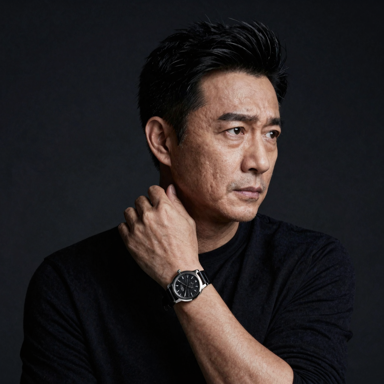

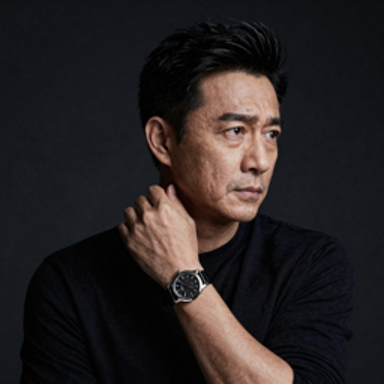

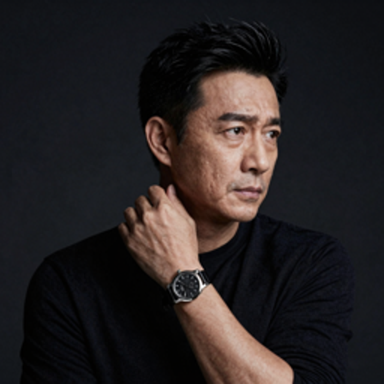

In [ ]:
import torchvision.transforms.functional as TF

def simple_x4_degrade(pil_img: Image.Image):
    hr = pil_img
    lr_size = (hr.size[0]//4, hr.size[1]//4)
    lr = hr.resize(lr_size, resample=Image.BICUBIC)
    # Many SR models condition on upsampled LR
    lr_up = lr.resize(hr.size, resample=Image.BICUBIC)
    return lr, lr_up

# Demo on the first sample
demo_dir = pairs_dir / f"{0:06d}"
x0 = Image.open(demo_dir / "x0.png").convert("RGB")
lr, lr_up = simple_x4_degrade(x0)

display(x0.resize((384,384)))
display(lr.resize((384,384)))
display(lr_up.resize((384,384)))


In [ ]:
import os
from PIL import Image
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm

def simple_x4_degrade(pil_img: Image.Image):
    hr = pil_img
    lr_size = (hr.size[0]//4, hr.size[1]//4)
    lr = hr.resize(lr_size, resample=Image.BICUBIC)
    # Many SR models condition on upsampled LR
    lr_up = lr.resize(hr.size, resample=Image.BICUBIC)
    return lr, lr_up

# Define the directory where pairs are saved
pairs_dir = Path("./zimage_offline_pairs/pairs")

print(f"Processing and saving LR images to: {pairs_dir}")

# Iterate through each sample directory
for i in tqdm(range(N), desc="Generating and saving LR images"):
    sample_dir = pairs_dir / f"{i:06d}"

    # Ensure the directory exists and x0.png is present
    x0_path = sample_dir / "x0.png"
    if not x0_path.exists():
        print(f"Warning: x0.png not found in {sample_dir}. Skipping.")
        continue

    # Load x0 image
    x0 = Image.open(x0_path).convert("RGB")

    # Degrade to LR and upsampled LR
    lr, lr_up = simple_x4_degrade(x0)

    # Save the degraded images
    lr.save(sample_dir / "lr.png")
    lr_up.save(sample_dir / "lr_up.png")

print("Finished saving all LR images.")

Processing and saving LR images to: zimage_offline_pairs/pairs


Generating and saving LR images:   0%|          | 0/1200 [00:00<?, ?it/s]

Finished saving all LR images.


In [ ]:
# New zip file name for the updated dataset including LR images
zip_filename_with_lr = "zimage_offline_pairs_with_lr.zip"

# Destination path in Google Drive (using the previously defined drive_path)
output_zip_path_with_lr = os.path.join(drive_path, zip_filename_with_lr)

# Create the new zip file
print(f"Zipping {input_dir} (including LR images) to {zip_filename_with_lr}...")
!zip -r {zip_filename_with_lr} {input_dir}

# Move the new zip file to Google Drive
print(f"Moving {zip_filename_with_lr} to {drive_path}...")
!mv {zip_filename_with_lr} {output_zip_path_with_lr}

print(f"Successfully zipped {input_dir} with LR images and saved it to {output_zip_path_with_lr}")

Streaming output truncated to the last 5000 lines.
  adding: zimage_offline_pairs/pairs/000957/lr_up.png (deflated 0%)
  adding: zimage_offline_pairs/pairs/000957/lr.png (deflated 0%)
  adding: zimage_offline_pairs/pairs/000957/x0.png (deflated 0%)
  adding: zimage_offline_pairs/pairs/000957/z0.pt (deflated 24%)
  adding: zimage_offline_pairs/pairs/000051/ (stored 0%)
  adding: zimage_offline_pairs/pairs/000051/eps.pt (deflated 21%)
  adding: zimage_offline_pairs/pairs/000051/lr_up.png (deflated 0%)
  adding: zimage_offline_pairs/pairs/000051/lr.png (deflated 0%)
  adding: zimage_offline_pairs/pairs/000051/x0.png (deflated 0%)
  adding: zimage_offline_pairs/pairs/000051/z0.pt (deflated 24%)
  adding: zimage_offline_pairs/pairs/000351/ (stored 0%)
  adding: zimage_offline_pairs/pairs/000351/eps.pt (deflated 21%)
  adding: zimage_offline_pairs/pairs/000351/lr_up.png (deflated 0%)
  adding: zimage_offline_pairs/pairs/000351/lr.png (deflated 0%)
  adding: zimage_offline_pairs/pairs/000351/

## 4) What you train later (high-level)

For FluxSR-style one-step SR distillation, training typically needs:
- `eps` (noise latent)
- `z0` (HR latent)
- `xL` / `zL` (LR or its latent), produced by degrading `x0`

Key identities (rectified flow / straight path):
- teacher velocity (latent): `u = eps - z0`
- LR velocity (latent): `uL = eps - zL`
- LR→HR is constrained via the FTD “triangle”.

This notebook stops at building the offline dataset and creating LR placeholders.  
Next step is a training script that:
- loads `(eps, z0, x0)` tuples
- generates degraded LR (`xL`) and encodes to `zL`
- predicts SR update in **one step** from `zL` (and optional text) and matches FTD losses
